In [2]:
!pip3 install pycuda
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 36.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 69 kB 9.3 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=f20bc7cbee93151d21a8de84d6af6e6be31a64c2b1dd76fddac7657fc40f8b09
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=a1143712d67e9033d929631227f7fa34250216acafd2e7706b7861a5461eeaba
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built pycuda pytools
Looking in indexes: https://pypi.or

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import njit, jit, float64

import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

cuda_code =  SourceModule("""

   #include <curand_kernel.h>

   __device__ inline int pbc(int x, int L);
   
   __global__ void init_particles(double *rin, 
                                  double *rout, 
                                  double rmin1,
                                  double eps1,
                                  double rmin2
                                  double eps2,
                                  int n1,
                                  int ntot)
    {
        int i = threadIdx.x + blockIdx.x*blockDim.x;
        int j = threadIdx.y + blockIdx.y*blockDim.y;
        curandState state;
        

        curand_init(clock64(), i, 0, &state);
    }


   __global__ void forces(double *arr_in, 
                             double *arr_out,
                             double D,
                             int nr, 
                             int nc)
    {
      
      int i = threadIdx.x+ blockIdx.x* blockDim.x;
      int j = threadIdx.y+ blockIdx.y* blockDim.y;

      int n = pbc(i-1,nr);
      int s = pbc(i+1,nr);
      int w = pbc(j-1,nc);
      int e = pbc(j+1,nc);

      arr_out[i*nc+j] =  arr_in[i*nc+j] +
                         D*(arr_in[n*nc+j] + arr_in[s*nc+j] +
                            arr_in[i*nc+w] + arr_in[i*nc+e] -
                            4.0*arr_in[i*nc+j]);
    }

    __device__ inline double sqrdist(double x1, double y1, double z1,
                                    double x2, double y1, double z2)
    {
        double dx, dy, dz;
        dx = x2-x1;
        dy = y2-y1;
        dz = z2-z1;
        d = dx*dx + dy*dy + dz*dz;
        return d;
    }


    __device__ inline int pbc(int x, int L)
    {
        return  x - (int)floor((double)x/L)*L;
    }

""")



@njit('float64(float64, float64)')
def pbc(x, L):
  """

  """
  return x - np.floor(x/L)*L;


@njit
def sqrdist(r1, r2, Lx, Ly, Lz):
  """

  """
  dx = pbc(r1[0]-r2[0], Lx)
  dy = pbc(r1[1]-r2[1], Ly)
  dz = pbc(r1[2]-r2[2], Lz)
  return dx*dx + dy*dy + dz*dz

@njit
def dthr_colls(id1, id2, r1, r2, ncoll1):
  """

  """
  dthr=0
  if id1<ncoll1 and id2<ncoll1:
    dthr=4*r1*r1
  elif id1>=ncoll1 and id2>=ncoll1:
    dthr=4*r2*r2
  else:
    dthr=(r1+r2)**2

  return dthr


@njit
def init_particles(R1, R2, Lx, Ly, Lz, ntot, frac_c1):
  """

  """

  Lx = np.float64(Lx)
  Ly = np.float64(Ly)
  Lz = np.float64(Lz)
  R1 = np.float64(R1)
  R2 = np.float64(R2)
  # Calculate the fraction of each colloid
  ncoll1 = int(np.round(ntot*frac_c1))

  # Puts first particle
  r = np.zeros(3*ntot, dtype=np.float64)

  r[0] = (2*Lx)*np.random.rand() - Lx
  r[1] = (2*Ly)*np.random.rand() - Ly
  r[2] = (2*Lz)*np.random.rand() - Lz
  n_pos = 1

  # Position the rest of the particles ensuring they do not overlap
  d=Lx*Lx
  dthr=1.01*d
  while(n_pos<ntot):
    d=0
    r[n_pos*3 + 0] = (2*Lx)*np.random.rand() - Lx
    r[n_pos*3 + 1] = (2*Ly)*np.random.rand() - Ly
    r[n_pos*3 + 2] = (2*Lz)*np.random.rand() - Lz
    dthr = dthr_colls(0, n_pos, R1, R2, ncoll1)
    
    for i in range(0, n_pos):
      d = sqrdist(r[i:i+3], r[n_pos:n_pos+3], Lx, Ly, Lz)
      dthr = dthr_colls(0, n_pos, R1, R2, ncoll1)
      if d<dthr: 
        break

    n_pos+=1

  return r, ncoll1



def brown():

  maxtime = 2
  R1 = 20
  R2 = 5
  Lx = 1000
  Ly = 500
  Lz = 500
  ntot = 20000
  frac_c1 = 8/10
  r, ncoll1 =  init_particles(R1, R2, Lx, Ly, Lz, ntot, frac_c1)


  # Plot (to function)
  r = r.reshape((ntot, 3))
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(r[0:ncoll1,0], r[0:ncoll1,1], r[0:ncoll1,2], color=(0.0, 0.0, 0.8, 1.0))
  ax.scatter(r[ncoll1:ntot,0], r[ncoll1:ntot,1], r[ncoll1:ntot,2], color=(0.8, 0.0, 0.0, 1.0))
  #for in range(0, maxtime):




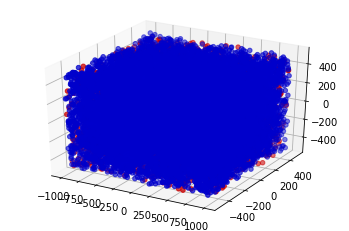

In [68]:
brown()